In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [3]:
def KL(theta0, theta1, k=1, device='cpu', p=float('inf'), beta=1.):
    """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions
            theta1 (Tensor): Samples, R X NbDimensions
            k (Int): positive ordinal number

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """

    n0 = theta0.shape[0]
    n1 = theta1.shape[0]
    dim0 = theta0.shape[1]
    dim1 = theta1.shape[1]
    assert dim0 == dim1

    D0 = torch.cdist(theta0, theta0, p=p)
    D1 = torch.cdist(theta0, theta1, p=p)

    a0 = torch.topk(D0, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k - 1]  # .clamp(torch.finfo().eps,float('inf')).to(device)

    assert a0.shape == a1.shape, 'dimension do not match'

    d = torch.as_tensor(float(dim0), device=device)
    N0 = torch.as_tensor(float(n0), device=device)
    N1 = torch.as_tensor(float(n1), device=device)

    Mnn = torch.log(a1).mean() - beta*torch.log(a0).mean()
    return d * Mnn + N1.log() - (N0 - 1).log()

In [4]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5



#optimizer
learning_rate=0.005

#scheduler
patience=25
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")
torch.manual_seed(42)

# Setup #

In [6]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='concrete' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=1.#setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
print(size_data)
#batch_size
batch_size=50#int(np.min([size_data/6,500]))
if dataset=='powerplant':
    batch_size=50

n_samples_FU=200 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0#30 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

1.0
927


# Predictive model #

In [7]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

param_count

501

# ELBO

## Average Log Likelihood

In [8]:
#average log likelihood loss 
###!!!!!!! TODO
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(dim=1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [9]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
    epsilon=0.1
    M = x_train.max(0, keepdim=True)[0]+epsilon
    m = x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


def kl(x_data, GeN, beta):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=beta)
    return K

def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [10]:
#ELBO
 #KL regularizer
    
def ELBO(x_data, y_data, GeN):
    alpha=(len(x_data)/size_data)
    beta=1.
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl(x_data, GeN, beta)
    the_ELBO= - Average_LogLikelihood+ alpha* the_KL#(len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [11]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=501, bias=True)
  )
)


# Optimizer

In [12]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [13]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [14]:
KLs=[]
ELBOs=[]
LRs=[]
LLs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[],
              'KL_train':[],
              'HMC_OOD':[],
              'HMC_train':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
        metrics.update({'KL_train': kl_train(GeN,x_train[:500]).item()})
        metrics.update({'HMC_OOD': kl_HMC_OOD(GeN).item()})
        metrics.update({'HMC_train': kl_HMC_train(GeN,x_train[:500]).item()})
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



  5%|▍         | 240/5000 [02:24<47:37,  1.67it/s, ELBO=44.7, KL=-71.9, LogLike=-48.5, lr=0.005]

Epoch   240: reducing learning rate of group 0 to 2.5000e-03.


  5%|▌         | 266/5000 [02:40<47:11,  1.67it/s, ELBO=42.5, KL=-101, LogLike=-47.9, lr=0.0025] 

Epoch   266: reducing learning rate of group 0 to 1.2500e-03.


  9%|▊         | 435/5000 [04:01<29:58,  2.54it/s, ELBO=41.1, KL=-119, LogLike=-47.5, lr=0.00125]

Epoch   435: reducing learning rate of group 0 to 6.2500e-04.


  9%|▉         | 473/5000 [04:16<29:53,  2.52it/s, ELBO=40.9, KL=-122, LogLike=-47.4, lr=0.000625]

Epoch   473: reducing learning rate of group 0 to 3.1250e-04.


 10%|█         | 523/5000 [04:35<29:31,  2.53it/s, ELBO=40.7, KL=-124, LogLike=-47.3, lr=0.000313]

Epoch   523: reducing learning rate of group 0 to 1.5625e-04.


 13%|█▎        | 670/5000 [05:37<27:22,  2.64it/s, ELBO=40.5, KL=-126, LogLike=-47.2, lr=0.000156]

Epoch   670: reducing learning rate of group 0 to 1.0000e-04.


 13%|█▎        | 670/5000 [05:38<36:26,  1.98it/s, ELBO=40.5, KL=-126, LogLike=-47.2, lr=0.0001]  


# Results on test #

In [15]:
#compute metrics on test
from Metrics import LPP
results={}
log_device='cpu'
theta=GeN(2000).detach()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=True)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})
mu=y_train.mean()
sigma=y_train.std()
y_pred=mu*torch.ones_like(y_test)
sigma_noise_train=sigma.view(1,1,1)
ref_LPP=LPP(y_pred.unsqueeze(0), y_test, sigma_noise_train.view(1,1,1), 'cpu')[0]
metrics.update({'SLPP':metrics['LPP'][0]-ref_LPP})
print(std_y_train)
print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

tensor(16.8536, device='cuda:0')
concrete
RMSE: (6.255248546600342, 8.07908821105957)
LPP: (-0.9881142377853394, 0.11480987071990967)
WAIC: -0.9882735273131402
PICP: 1.0
MPIW: 66.15190124511719
time [s]: 338.3419686059933
SLPP: 0.3390927314758301


In [16]:
#compute metrics on test


results={}
log_device='cpu'
theta=prior(2000).detach()
y_pred=model(x_test,theta)
metrics_=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=True)
results.update({dataset:metrics_})

print(dataset)
print("prior's scores")
for m, r in metrics_.items():
    print(m+': '+str(r))

concrete
prior's scores
RMSE: (15.558462142944336, 17.94209098815918)
LPP: (-3.5553572177886963, 0.3176349699497223)
WAIC: -64083.15691971779
PICP: 1.0
MPIW: 1023.4593505859375


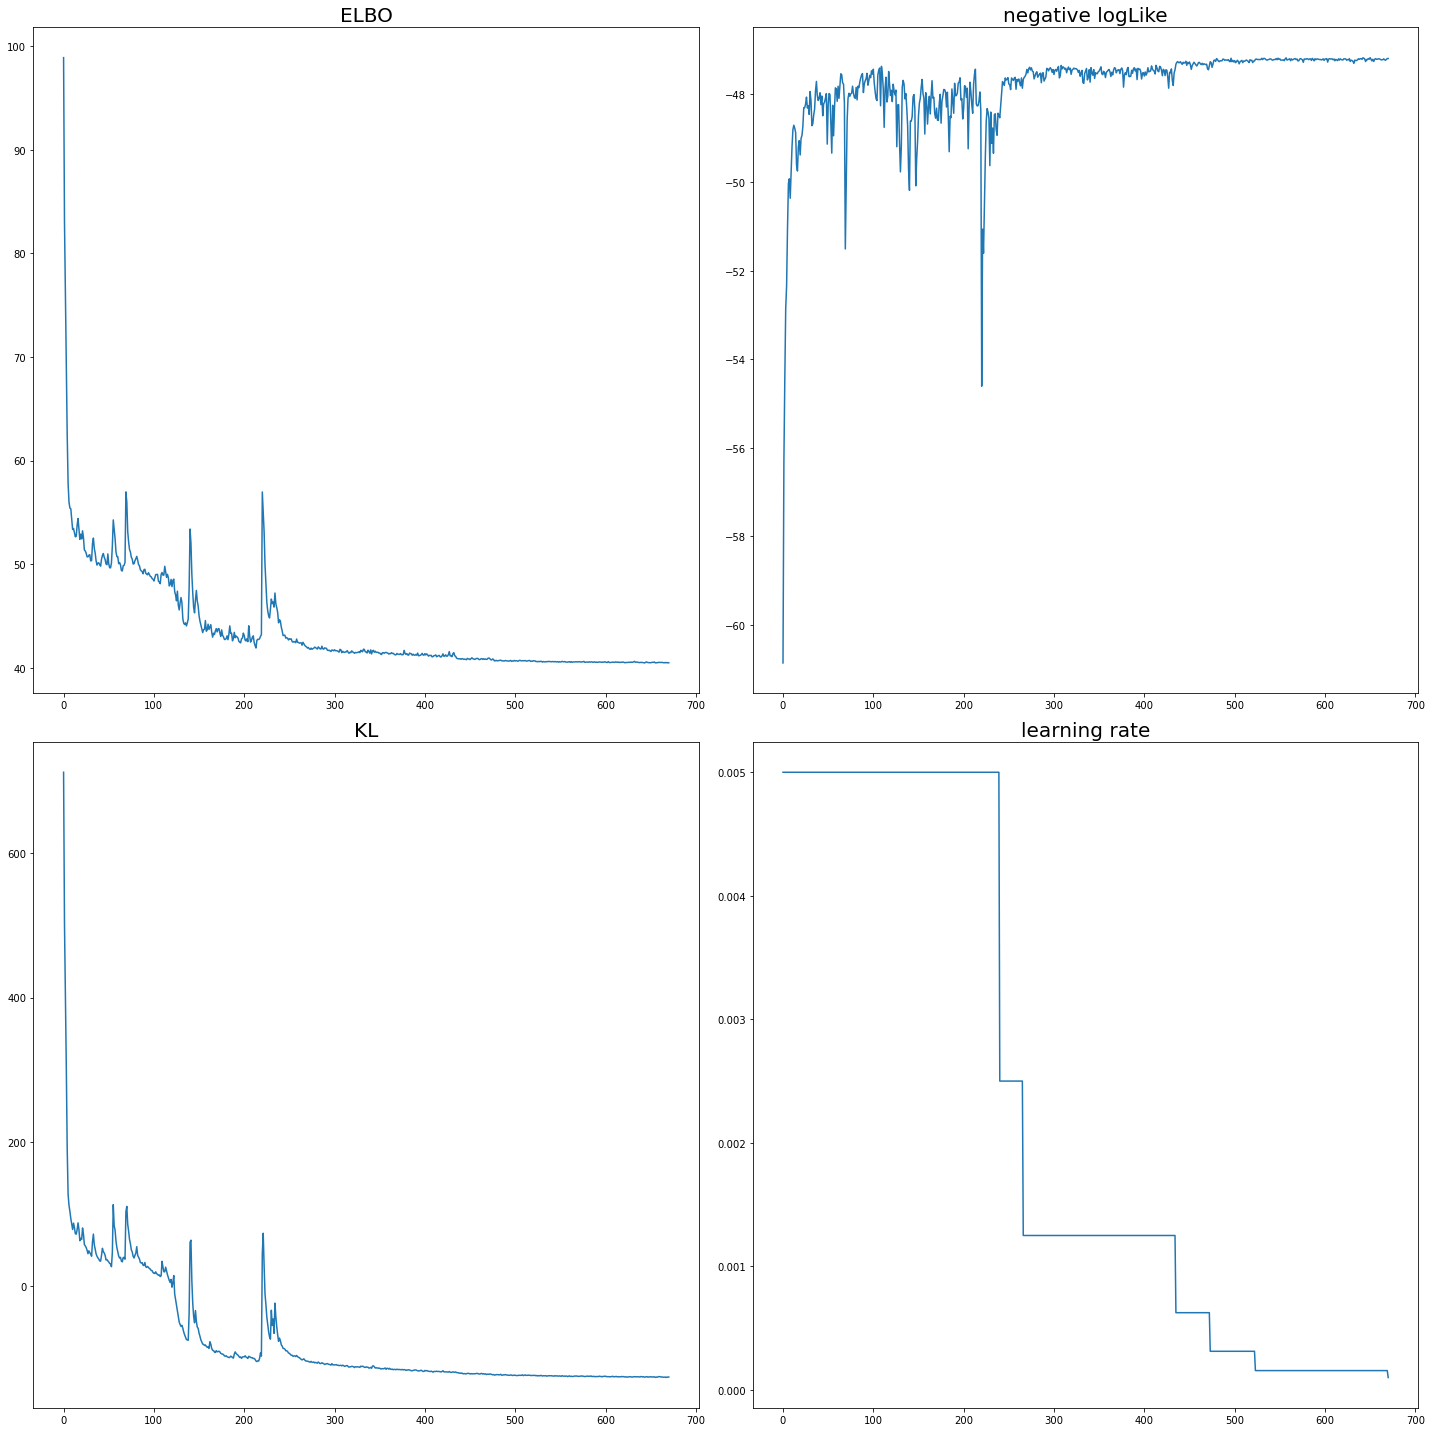

In [17]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LL_=torch.as_tensor(training['LL'])
LR_=torch.as_tensor(training['LR'])
fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

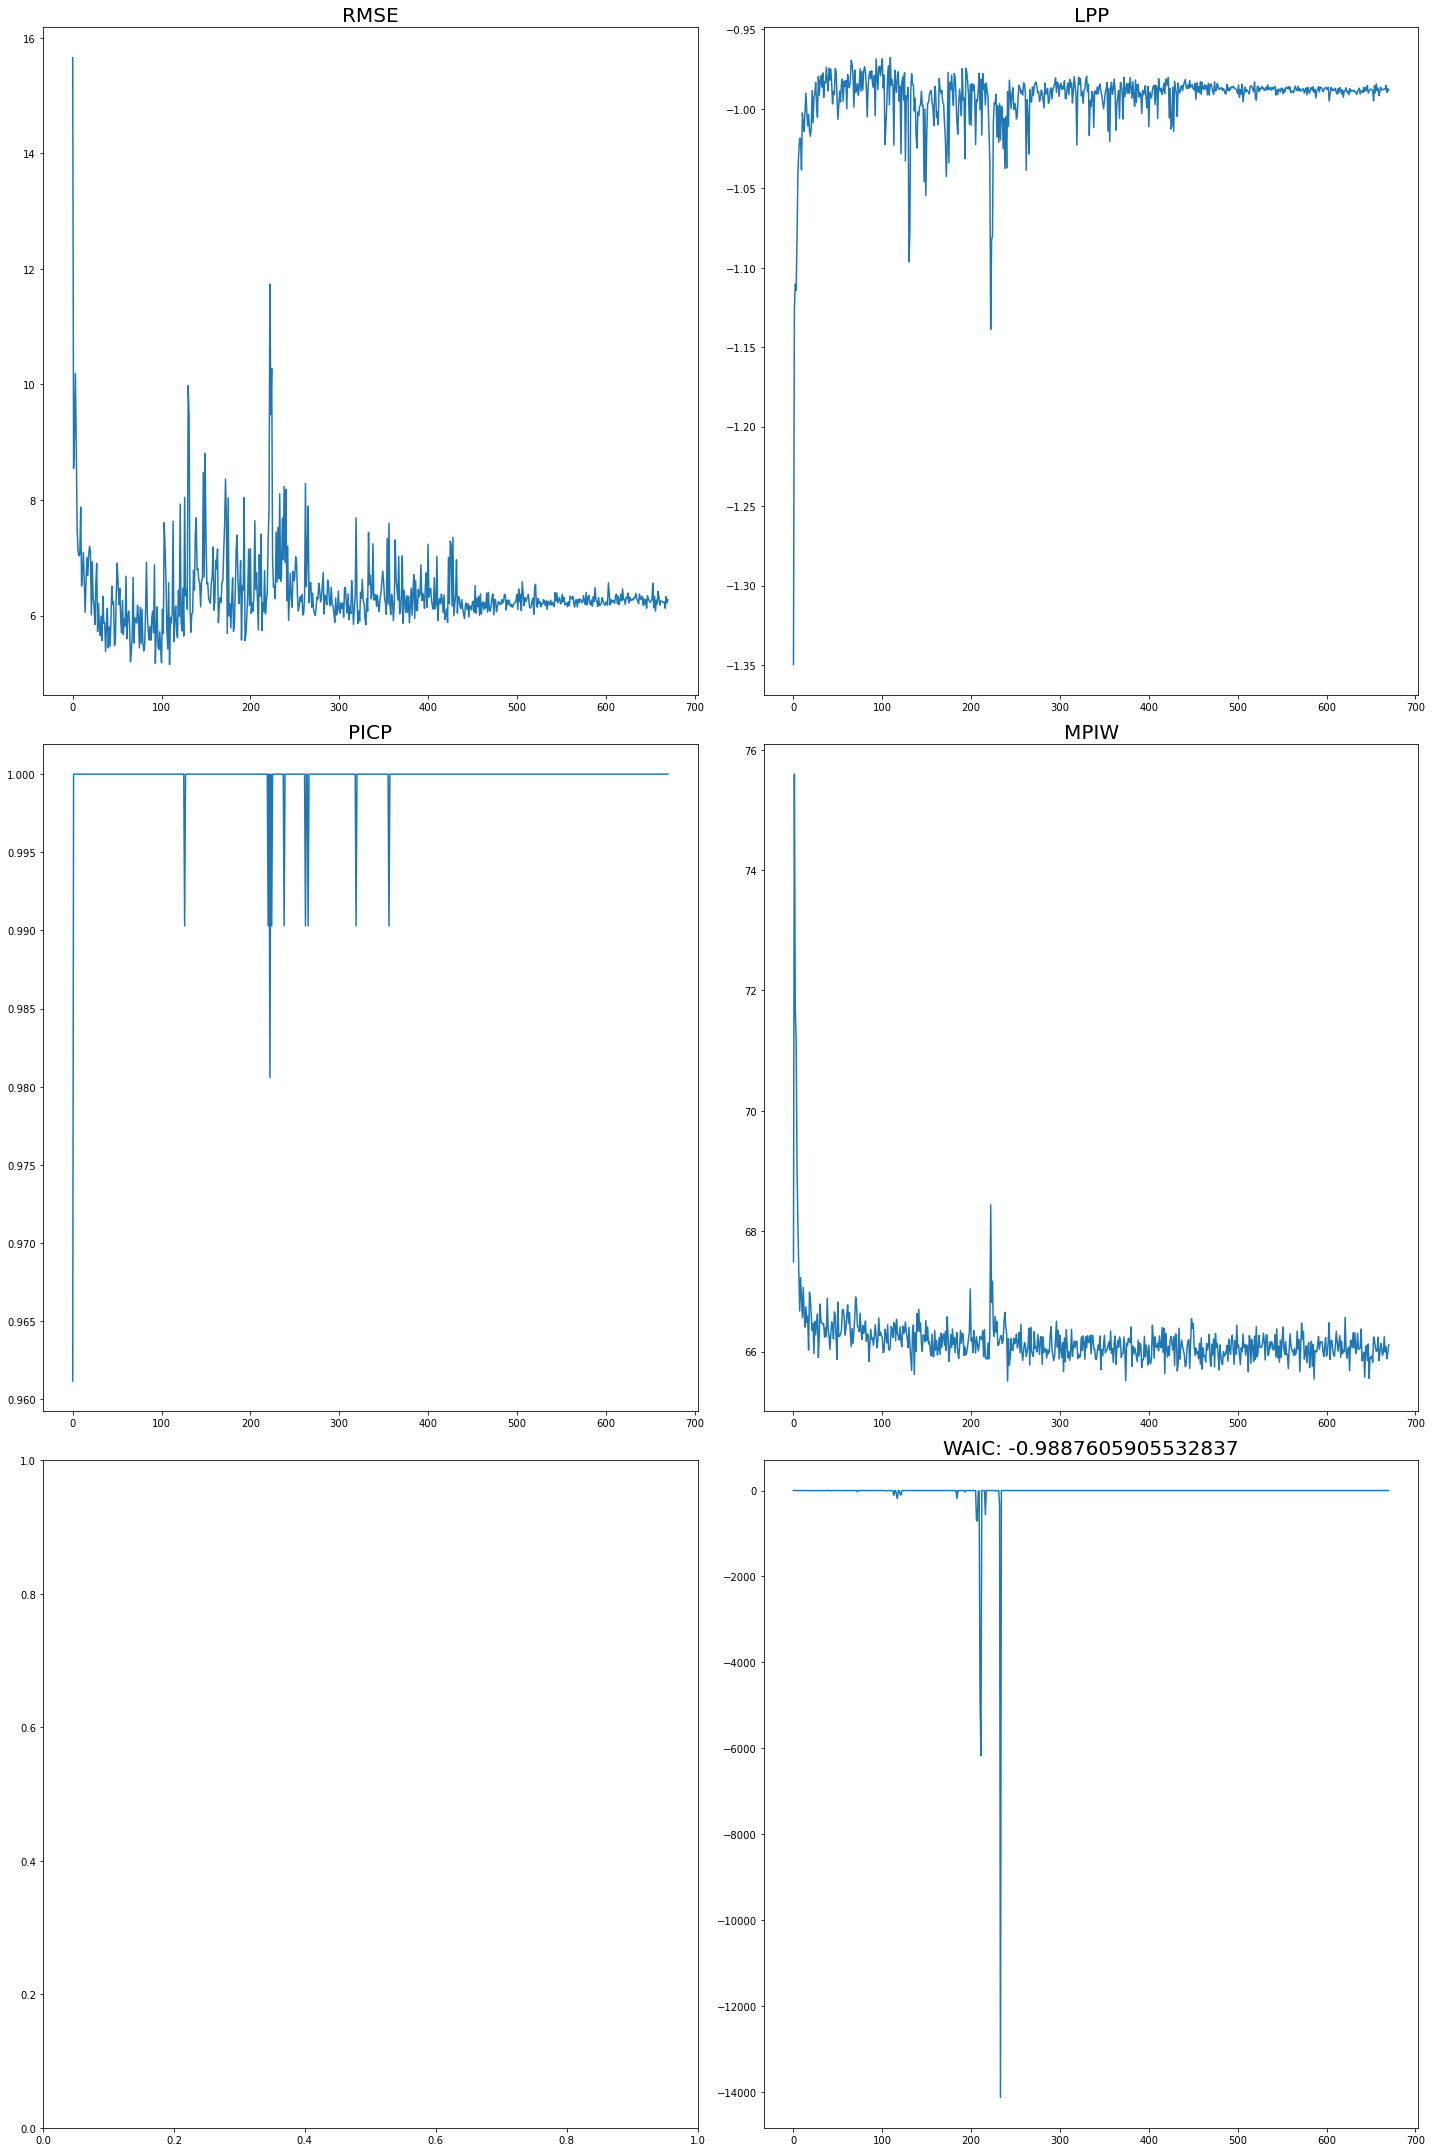

In [18]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(3,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
#m='KL_train'
#ax[2,0].plot(time_line,test_metrics[m])
#ax[2,0].set_title(m, fontsize=20)
m='WAIC'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
fig.tight_layout()

# posterior predictive diagnostic #

Text(0.5, 0.98, 'On train')

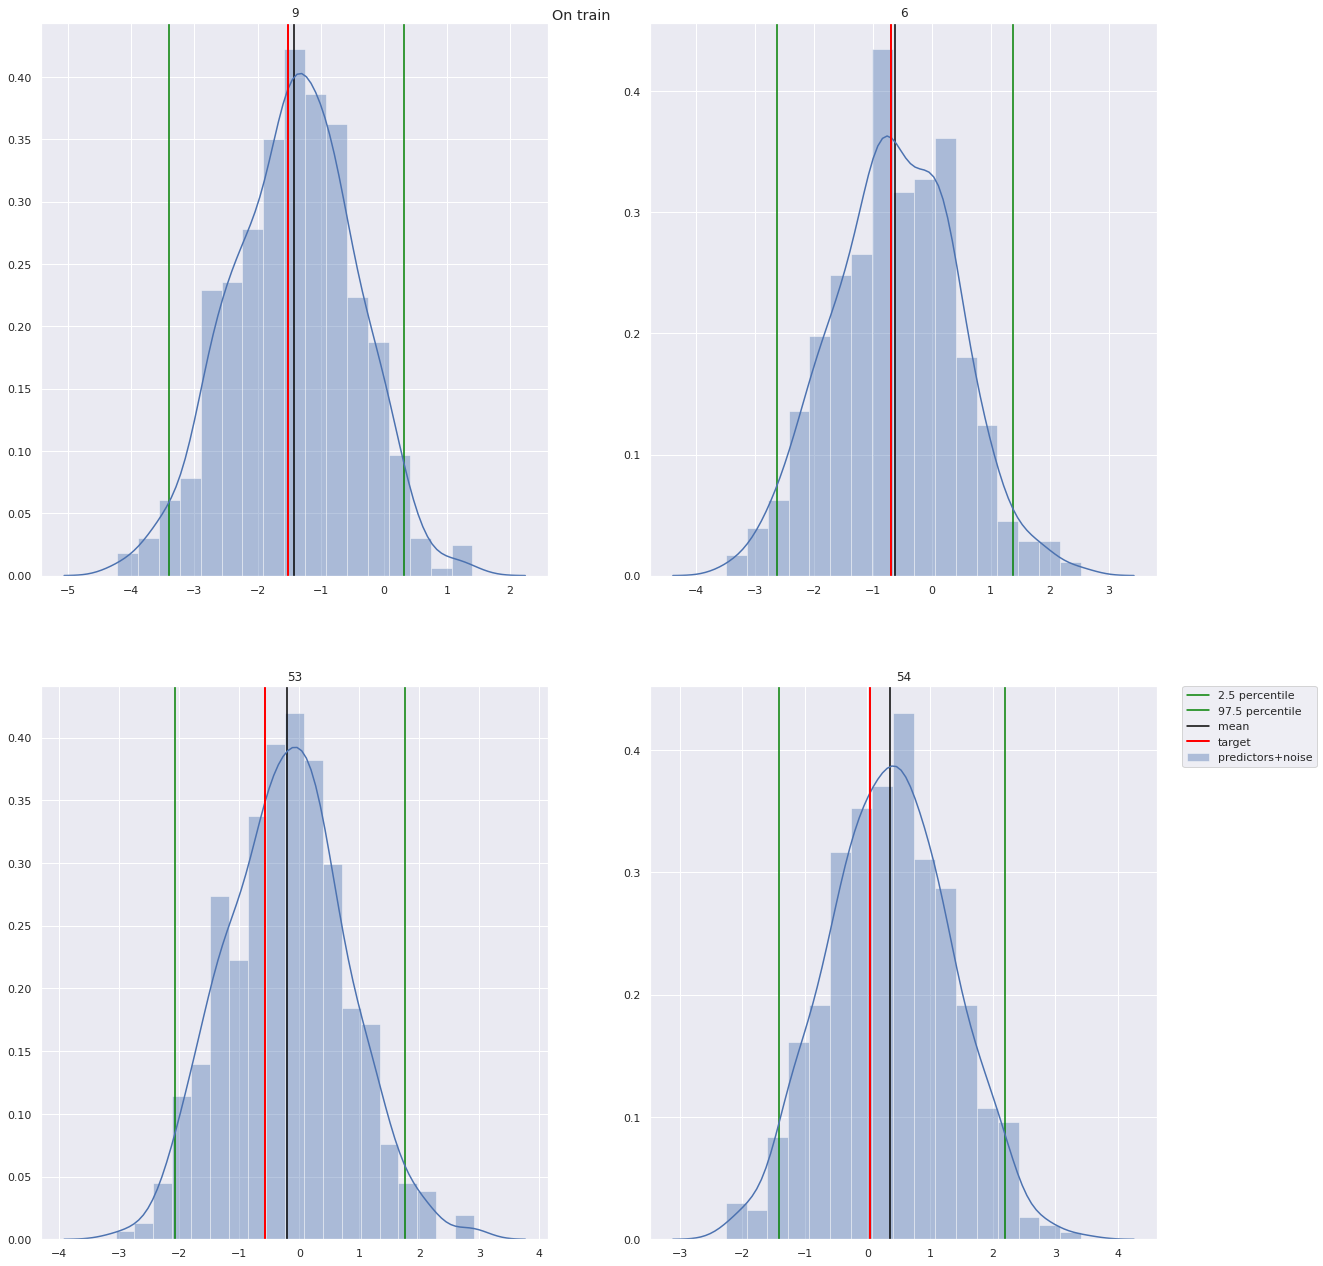

In [23]:
import seaborn as sns
from pylab import *


def predict(GeN, n, x):
    theta=GeN(n).detach()
    pred=model(x,theta)
    y_pred=pred+sigma_noise*torch.randn_like(pred)
    return y_pred

n_predictors=500
pred_=predict(GeN,n_predictors,x_train)


M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)



sns_plot=sns.set(rc={"figure.figsize": (20, 20)}, )
N=2
M=2

for _ in range(0,N*M):
    i=torch.randint(0,y_test.shape[0],()).item()
    subplot(N,M,_+1)

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', label='mean')
#    ax=sns.distplot(pred_prior[:,i], label='prior')
#    ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    ax =sns.distplot(pred_[:,i].cpu(),label='predictors+noise')
    line1=plt.axvline(y_train[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='On train')


Text(0.5, 0.98, 'RMSE on test=6.26, LPP on test=-0.99)')

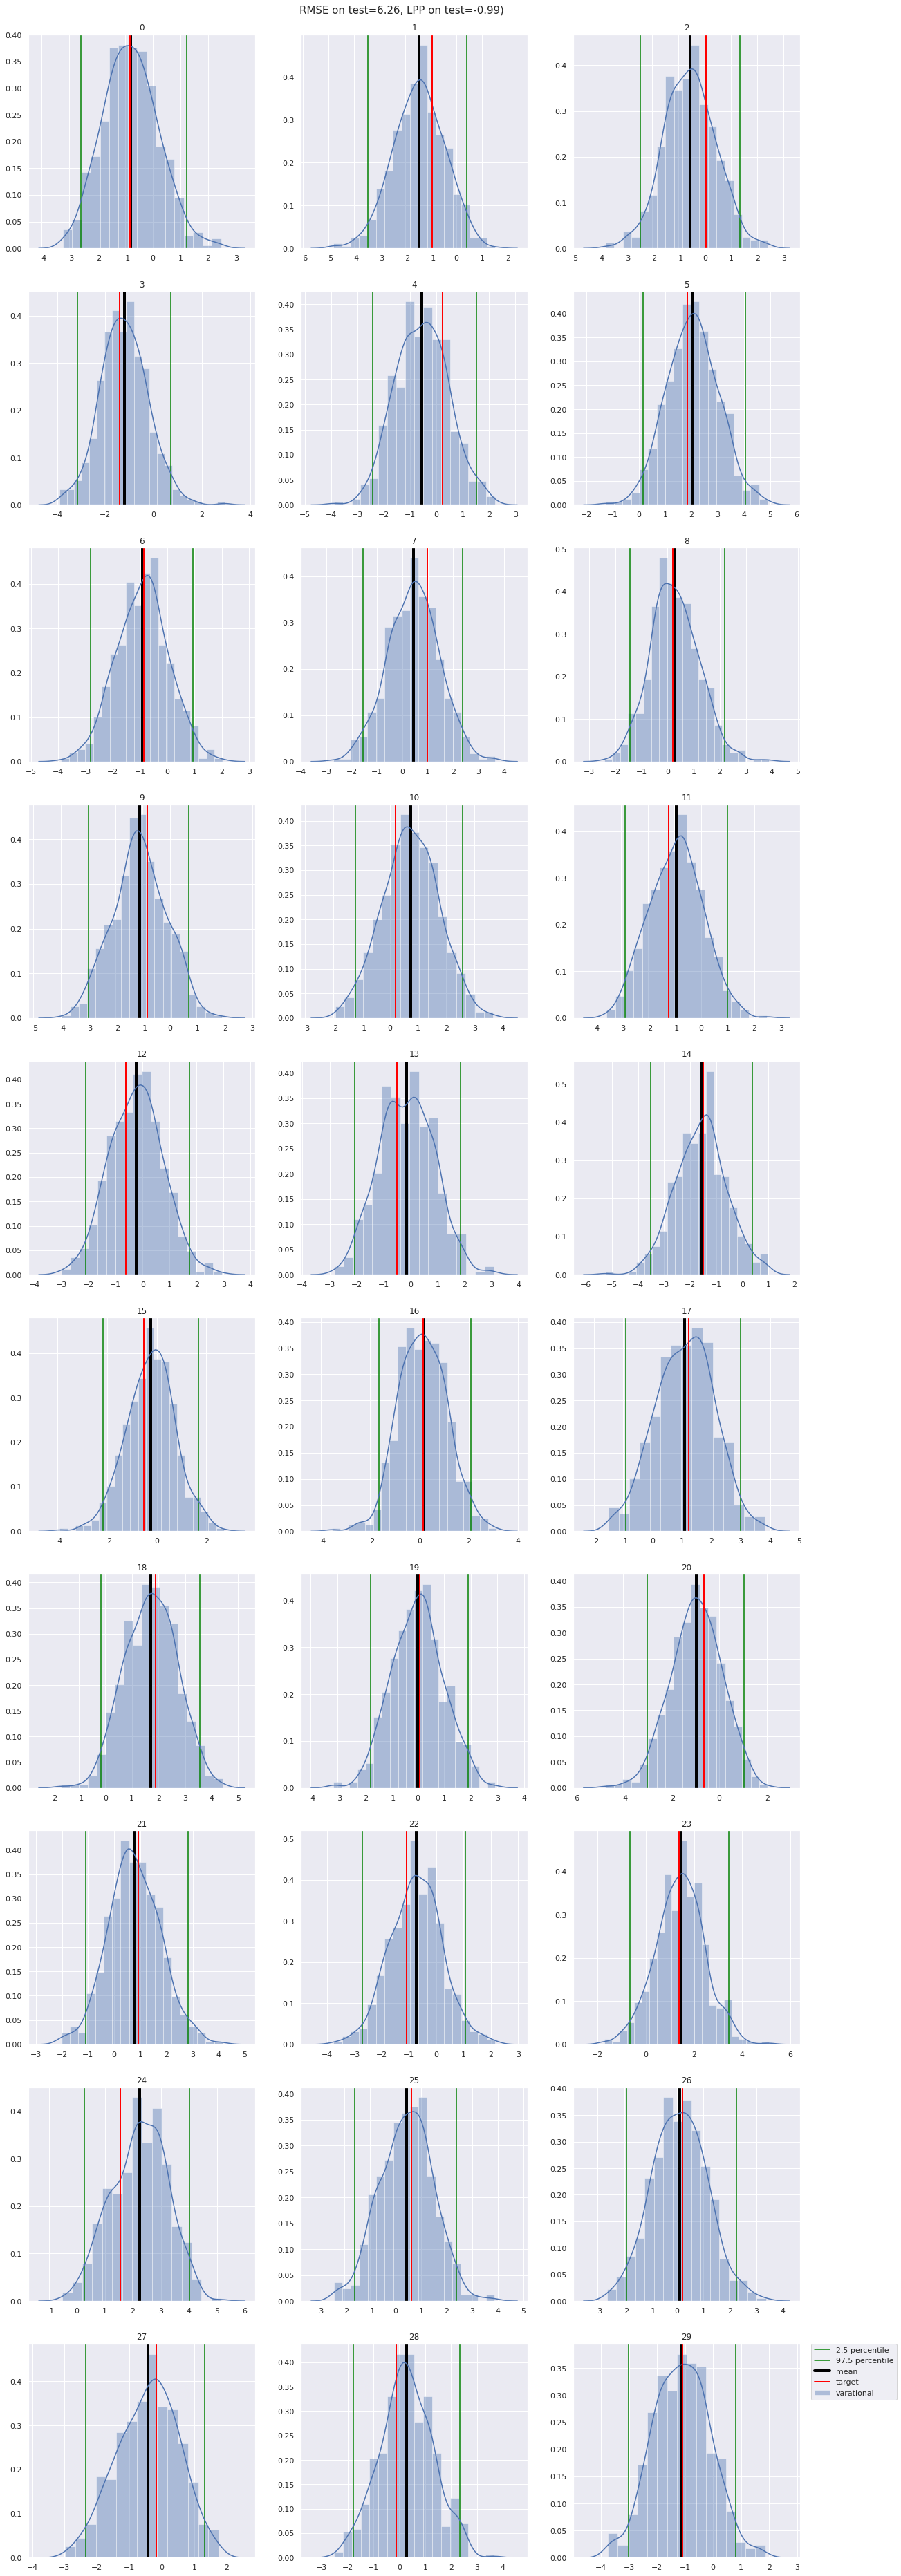

In [24]:
import seaborn as sns
from pylab import *

pred_=predict(GeN,n_predictors,x_test)

M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)


sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
N=10
M=3

for i in range(N*M):
    
    subplot(N,M,i+1)
#    plt.plot(lin_y.view(-1,300)[i].squeeze().cpu(),LPP[i].exp().cpu(), label='posterior predictive')

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', lw=4.,label='mean')
 #   ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    line5 =ax=sns.distplot(pred_[:,i].cpu(),label='varational')
    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='RMSE on test={:.2f}, LPP on test={:.2f})'.format(metrics['RMSE'][0],metrics['LPP'][0]),fontsize=15)


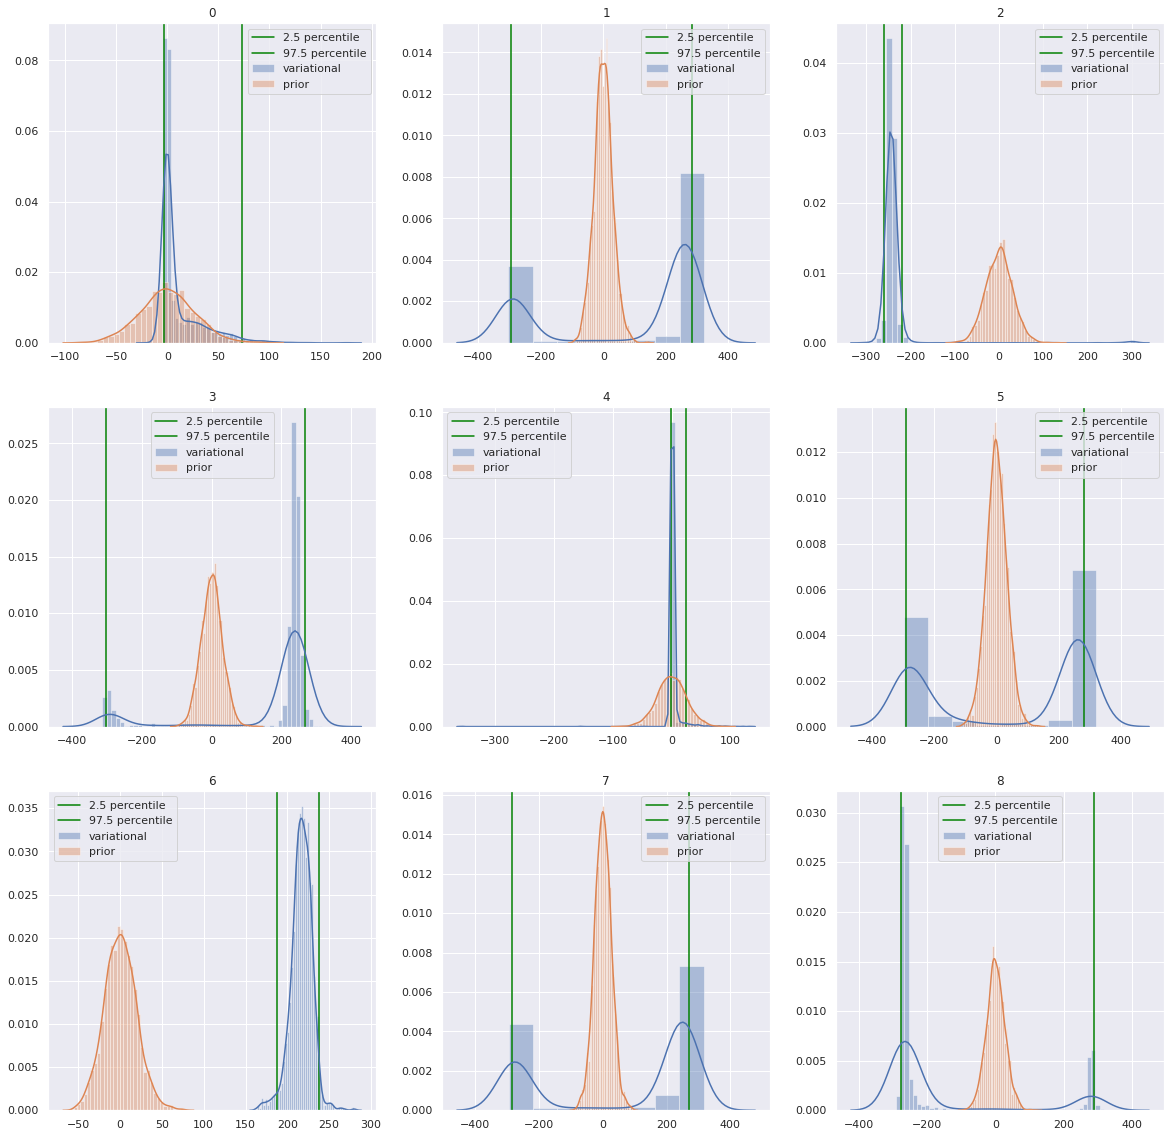

In [25]:
import seaborn as sns
from pylab import *


theta=GeN(2000).detach()
epsilon=0.1
n_ood=30
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  

pred=predict(GeN,2000,X_ood)
theta_prior=prior(2000)
pred_prior=model(X_ood,theta_prior)
pred_prior+= sigma_noise*torch.randn_like(pred)
M = pred.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].to(device)
y_high = y_pred_s[M_high, :].to(device)

sns.set(rc={"figure.figsize": (20, 20)})
N=3
for i in range(N**2):
    subplot(N,N,i+1)
    plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    plt.title(str(i))
    ax=sns.distplot(pred[:,i].cpu(), label='variational')
    ax=sns.distplot(pred_prior[:,i].cpu(), label='prior')
    plt.legend()


# Uncertainty vs Error #

In [32]:
X=[x_train,x_test]
y=[y_train,y_test]
label=['train', 'test']
def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)



for i in range(len(X)):
    pred=predict(GeN,500,X[i])

    M = pred.shape[0]
    print(M)
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))


    H=(Entropy(pred.transpose(0,1),k=20))
    STD=(pred.std(0).squeeze())
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    ax=sns.scatterplot(H.cpu(),MSE.cpu(), label=label[i])
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')

RuntimeError: CUDA out of memory. Tried to allocate 708.00 MiB (GPU 0; 10.76 GiB total capacity; 908.05 MiB already allocated; 142.75 MiB free; 918.00 MiB reserved in total by PyTorch)

In [33]:
epsilon=0.1
n_ood=1000
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
X=[x_train,x_test,X_ood]
label=['train','test','ood']
for i in range(len(X)):
    pred_=predict(GeN,1000,X[i])
    H=Entropy(pred_.transpose(0,1),k=30)
    ax=sns.distplot(H, label=label[i])
plt.legend()


RuntimeError: CUDA out of memory. Tried to allocate 1.38 GiB (GPU 0; 10.76 GiB total capacity; 910.02 MiB already allocated; 142.75 MiB free; 918.00 MiB reserved in total by PyTorch)

In [34]:
from Tools import log_norm
def WAIC(y_pred, sigma_noise, y_test,  device):
    log_proba = log_norm( y_test.unsqueeze(1), y_pred, sigma_noise).view(y_pred.shape[0],y_pred.shape[1])    
    M = torch.tensor(y_pred.shape[0], device=log_proba.device).float()
    LPP = log_proba.mean(dim=0)    
    pWAIC = log_proba.var(dim=0)
    return LPP-pWAIC

def predict(GeN, n, x):
    theta=GeN(n).detach()
    pred=model(x,theta)
    y_pred=pred+sigma_noise*torch.randn_like(pred)
    return y_pred
y_pred=predict(GeN,1000,x_test)
waic_test=WAIC(y_pred, torch.tensor(sigma_noise, device=device).view(1,1,1), y_test,  device)
y_pred=predict(GeN,1000,x_train)
waic_train=WAIC(y_pred, torch.tensor(sigma_noise, device=device).view(1,1,1), y_train,  device)

sns.distplot(waic_train.cpu(), label='train')
ax=sns.distplot(waic_test.cpu(), label='test')
ax.set_xlim(-10,5)
plt.legend()

RuntimeError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 10.76 GiB total capacity; 911.93 MiB already allocated; 142.75 MiB free; 918.00 MiB reserved in total by PyTorch)